Data Exploration - Business Only until now

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import ast

df_dict = {}
datasets = ['business', 'review', 'user'] #'checkin',  'tip',

for i in datasets:
    df = pd.read_csv(f'yelp_academic_dataset_{i}.csv')
    df_dict[f'df_{i}'] = df

df_business = df_dict['df_business']
df_user = df_dict['df_user']
df_review = df_dict['df_review']

print(df_business.head())

C:\Users\asus\AppData\Local\Temp\ipykernel_15900\3689886825.py:15: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'yelp_academic_dataset_{i}.csv')


              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.9555

In [ ]:
# df_check = pd.read_csv('yelp_academic_dataset_checkin.csv')
# df_tip = pd.read_csv('yelp_academic_dataset_tip.csv')

In [2]:
nulls = pd.DataFrame(df_business.isna().sum(), columns=['null_count'])
print(nulls)

              null_count
business_id            0
name                   0
address             5127
city                   0
state                  0
postal_code           73
latitude               0
longitude              0
stars                  0
review_count           0
is_open                0
attributes         13744
categories           103
hours              23223


There are some places without categorie. Delete them or Fill it based on their reviews...

In [3]:
from collections import Counter
from nltk import word_tokenize

#tokens = df_business["categories"].apply(lambda x: word_tokenize(str(x))) #[(',', 518349), ('&', 108359), ('Services', 56156), ('Restaurants', 52343), ('Food', 43813), ('Shopping', 24858), ('Home', 24169), ('Bars', 21022), ('Spas', 17070), ('Beauty', 15836)]
 #i will not use this, because i want to keep merged the categories like 'X & Y'

categories_split = df_business["categories"].apply(lambda x: [cat.strip() for cat in str(x).split(',')])
all_categories = [category for sublist in categories_split for category in sublist]
category_counter = Counter(all_categories)  #use Counter

print("Nº of categories: ", len(category_counter))


Nº of categories:  1312


Maybe we should use only top X categories, otherwise it's too sparse

[('Restaurants', 52268), ('Food', 27781), ('Shopping', 24395), ('Home Services', 14356), ('Beauty & Spas', 14292), ('Nightlife', 12281), ('Health & Medical', 11890), ('Local Services', 11198), ('Bars', 11065), ('Automotive', 10773)]


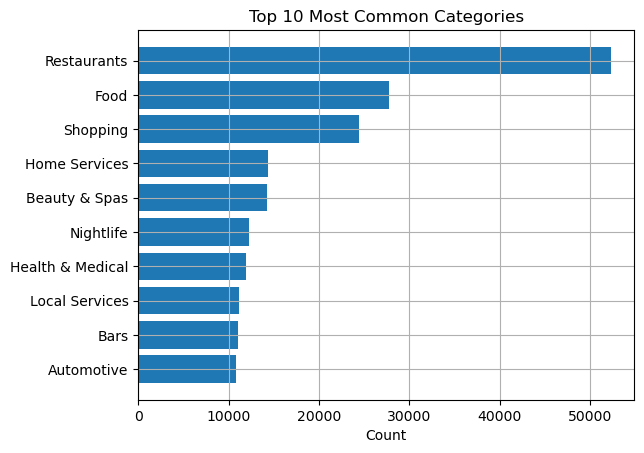

In [4]:
most_common_categories = category_counter.most_common(10)
print(most_common_categories)  

categories, counts = zip(*most_common_categories)

plt.figure()
plt.barh(categories, counts)
plt.xlabel('Count')
plt.title('Top 10 Most Common Categories')
plt.gca().invert_yaxis() 
plt.grid()
plt.show()

In [5]:
df_business = df_business[df_business["is_open"] == 1]
# df_business = businesses_df[(businesses_df['city'] == 'Philadelphia') & (businesses_df['categories'].str.contains('Restaurants', na=False))].reset_index(drop=True)

In [12]:
restaurants_df = df_business[df_business["categories"].str.contains('Restaurants', na=False)]
restaurants_df.head(50)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': ""u'quiet'"", 'GoodForMeal': ""{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
22,kfNv-JZpuN6TVNSO6hHdkw,Hibachi Express,6625 E 82nd St,Indianapolis,IN,46250,39.904320,-86.053080,4.0,20,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Steakhouses, Asian Fusion, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
23,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.476117,-119.789339,2.5,339,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Restaurants, Italian","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
29,sqSqqLy0sN8n2IZrAbzidQ,Domino's Pizza,3001 Highway 31 W,White House,TN,37188,36.464747,-86.659187,3.5,8,1,{'RestaurantsPriceRange2': '1'},"Pizza, Chicken Wings, Sandwiches, Restaurants","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."


In [32]:
pd.set_option('display.max_colwidth', 150)
# print(restaurants_df[['attributes']].head(20))

                                                                                                                                               attributes
3   {'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'BusinessAcceptsCreditCards': 'False', 'BusinessParking': "{'garage': False, 'street':...
5   {'BusinessParking': 'None', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsAttire': "u'casual'", 'OutdoorSeating': 'True', 'RestaurantsReservat...
9   {'RestaurantsAttire': "'casual'", 'RestaurantsGoodForGroups': 'False', 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'True', 'GoodForKid...
11  {'Alcohol': "'none'", 'OutdoorSeating': 'None', 'RestaurantsReservations': 'False', 'Ambience': "{'touristy': False, 'hipster': False, 'romantic':...
12  {'RestaurantsReservations': 'False', 'RestaurantsTakeOut': 'True', 'RestaurantsAttire': "'casual'", 'GoodForKids': 'True', 'BikeParking': 'False',...
15  {'RestaurantsReservations': 'True', 'RestaurantsGoodForGroups': 'True', 

I would suggest to convert the main categories into new features 
For now, I will convert them in a dictionary to be simple to filter and analyze

In [ ]:
restaurants_df = df_business[df_business["categories"].str.contains('Restaurants', na=False)]

restaurants_df['attributes'] = restaurants_df['attributes'].fillna('{}') # fill NaN values with empty dictionaries
restaurants_df['attributes'] = restaurants_df['attributes'].apply(ast.literal_eval) # from string representations into  dicionaries

# Filter restaurants that offer delivery
delivery_restaurants = restaurants_df[restaurants_df['attributes'].apply(lambda x: x.get('RestaurantsDelivery') == 'True')]

In [49]:
df_business['delivery'] = restaurants_df['attributes'].apply(lambda x: x.get('RestaurantsDelivery') == 'True')

# Fill NaN values in the new 'delivery' column with False (for non-restaurants)
df_business['delivery'] = df_business['delivery'].fillna(False)

# Display the first 10 rows of the updated DataFrame
print(df_business[['name', 'delivery']].head(10))

                        name  delivery
1              The UPS Store     False
3         St Honore Pastries     False
4   Perkiomen Valley Brewery     False
5             Sonic Drive-In      True
6            Famous Footwear     False
7             Temple Beth-El     False
9             Sonic Drive-In      True
10                 Marshalls     False
11     Vietnamese Food Truck     False
12                   Denny's      True


C:\Users\asus\AppData\Local\Temp\ipykernel_4728\1947569722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business['delivery'] = restaurants_df['attributes'].apply(lambda x: x.get('RestaurantsDelivery') == 'True')
C:\Users\asus\AppData\Local\Temp\ipykernel_4728\1947569722.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_business['delivery'] = df_business['delivery'].fillna(False)
C:\Users\asus\AppData\Local\Temp\ipykernel_4728\1947569722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

And do the same for 'Categories'?

In [33]:
print(restaurants_df[['categories']].head(20))


                                                                                                           categories
3                                                           Restaurants, Food, Bubble Tea, Coffee  and  Tea, Bakeries
5                                    Burgers, Fast Food, Sandwiches, Food, Ice Cream  and  Frozen Yogurt, Restaurants
9                                                Ice Cream  and  Frozen Yogurt, Fast Food, Burgers, Restaurants, Food
11                                                                         Vietnamese, Food, Restaurants, Food Trucks
12                                                American (Traditional), Restaurants, Diners, Breakfast  and  Brunch
15                                                                                  Sushi Bars, Restaurants, Japanese
19                                                                                                Korean, Restaurants
22                                                      

Observações:
* Há atributos repetidos: como 'None' e 'none'


In [ ]:
#criar atributo que indica se está aberto ao fim de semana